In [7]:
import jax.numpy as jnp
from jax import jit 
from jax.flatten_util import ravel_pytree

import numpy as np
import scipy
import matplotlib.pyplot as plt
import interpax

from adoptODE import train_adoptODE, simple_simulation, dataset_adoptODE
from mechanics import *
from data_reading import *
import progressbar

In [8]:
mode = "chaos"

"""
    Reads in necessary parameters from config.ini
"""

print("Preparing data...")
N,size,[] = read_config([])

print("Reading data...")
x_temp = read_vector("../data/SpringMassModel/x.csv",(N,2,size+1,size+1))
x_cm_temp = read_vector("../data/SpringMassModel/x_cm.csv",(N,2,size+1,size+1))
T = read_scalar("../data/SpringMassModel/T.csv",(1,N,size,size))[0]
f = read_vector("../data/SpringMassModel/f.csv",(N,2,size+1,size+1))

Preparing data...
Reading data...
shape of data:  (2000, 2, 101, 101)


100% |########################################################################|


shape of data:  (2000, 2, 101, 101)


100% |########################################################################|


shape of data:  (1, 2000, 100, 100)


100% |########################################################################|


shape of data:  (2000, 2, 101, 101)


In [ ]:
def sm_model(**kwargs_sys):

    #bounds for parameters
    nu_min, nu_max = kwargs_sys['nu_min'], kwargs_sys['nu_max']
    m_min, m_max = kwargs_sys['m_min'], kwargs_sys['m_max']
    l_g_min, l_g_max = kwargs_sys['l_g_min'], kwargs_sys['l_g_max']
    l_p_min, l_p_max = kwargs_sys['l_p_min'], kwargs_sys['l_p_max']
    k_g_min, k_g_max = kwargs_sys['k_g_min'], kwargs_sys['k_g_max']
    k_a_min, k_a_max = kwargs_sys['k_a_min'], kwargs_sys['k_a_max']
    k_p_min, k_p_max = kwargs_sys['k_p_min'], kwargs_sys['k_p_max']
    eta_min, eta_max = kwargs_sys['eta_min'], kwargs_sys['eta_max']

    # Interpolated params and coresponding time ,
    x_cm_arr = kwargs_sys['x_cm']
    x_j_arr = kwargs_sys['x_j']
    l_a_arr = kwargs_sys['l_a']
    t_interp = kwargs_sys['t_interp']

    def gen_y0():

        #takes initial conditions from kwargs(data)
        x1_0 = kwargs_sys['x1_0']
        x2_0 = kwargs_sys['x2_0']
        y1_0 = kwargs_sys['y1_0']
        y2_0 = kwargs_sys['y2_0']
        la0_0 = kwargs_sys['la0_0']

        return {'x1':x1_0, 'x2':x2_0, 'y1':y1_0, 'y2':y2_0, 'la0':la0_0}

    def gen_params():

        nu = nu_min + (nu_max - nu_min) * np.random.rand()
        m = m_min + (m_max - m_min) * np.random.rand()

        l_g = l_g_min + (l_g_max - l_g_min) * np.random.rand()
        l_p = l_p_min + (l_p_max - l_p_min) * np.random.rand()

        k_g = k_g_min + (k_g_max - k_g_min) * np.random.rand()
        k_a = k_a_min + (k_a_max - k_a_min) * np.random.rand()
        k_p = k_p_min + (k_p_max - k_p_min) * np.random.rand()
        
        eta = eta_min + (eta_max - eta_min) * np.random.rand()

        return {'nu':nu,'m':m,'l_g':l_g,'l_p':l_p,'k_g':k_g, 'k_a':k_a,'k_p':k_p, 'eta':eta}, {}, {}

        
    @jit
    def eom(xy, t, params, iparams, exparams):
        
        # get interpolated parameters at corresponding time
        x_cm = t_to_value_x(x_cm_arr,t_interp,t)
        x_j = t_to_value_x(x_j_arr,t_interp,t)
        l_a = t_to_value_l(l_a_arr,t_interp,t)

        #initialize variables
        x = jnp.array([xy['x1'], xy['x2']])
        l_a[0] = xy['la0']

        #initialize total force
        f = total_force(x, x_j, x_cm, l_a, t, params)

        #initialize eom
        dx1 = xy['y1']
        dx2 = xy['y2']
        dy1 = 1/params['m'] * (f[0] - params['nu'] * xy['y1'])
        dy2 = 1/params['m'] * (f[1] - params['nu'] * xy['y2'])
        dla0 = grad(la0)

        return {'x1':dx1, 'x2':dx2, 'y1':dy1, 'y2':dy2}

    @jit
    def loss(xy, params, iparams, exparams, targets):
        
        x1 = xy['x1']
        x2 = xy['x2']
        t_x1 = targets['x1']
        t_x2 = targets['x2']
        return jnp.nanmean((x1-t_x1)**2 + (x2-t_x2)**2)

    return eom, loss, gen_params, gen_y0, {}

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


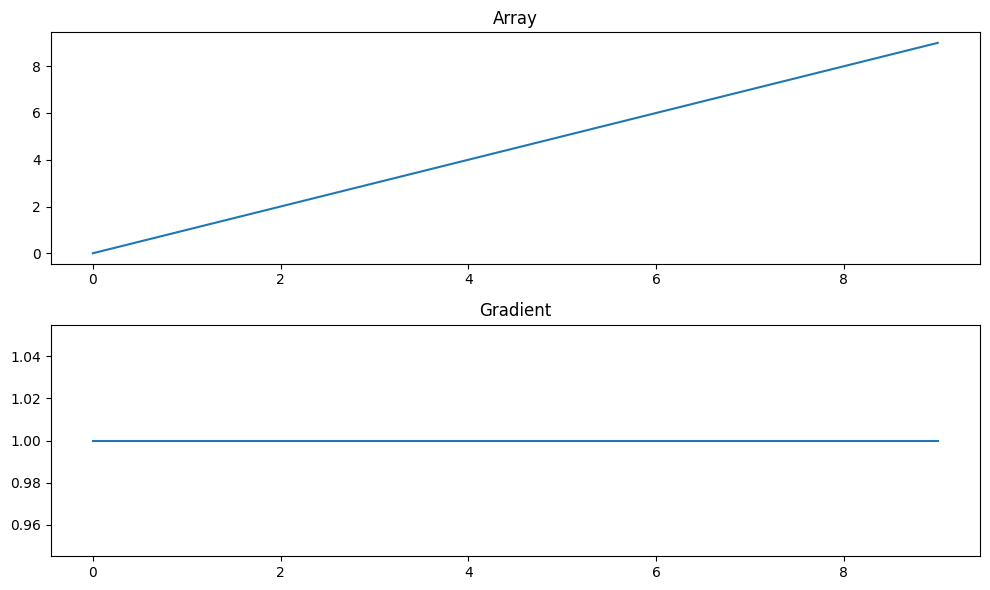

In [6]:
# Step 1: Import jax and jax.numpy
import jax
import jax.numpy as jnp

# Step 2: Define your one-dimensional array
array = x_i[:,0]

# Step 3: Define a function to compute the value
@jit
def func(x):
    return x  # Example function, modify as needed

# Step 4: Calculate the gradient
gradient_func = jax.grad(func)
gradient = gradient_func(array)

# Step 5: Print or use the gradient
print(gradient)
# Step 5: Plot the array and the gradient
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot the array
plt.subplot(2, 1, 1)
plt.plot(array)
plt.title('Array')

# Plot the gradient
plt.subplot(2, 1, 2)
plt.plot(gradient)
plt.title('Gradient')

plt.tight_layout()
plt.show()


In [ ]:
N,size,ls = read_config(["l_0","c_a","k_ij","k_j","k_a","m","c_damp","n_0","delta_t_m","it_m","pad"])
l_0, c_a, k_g0, k_p0, k_a0, m0, nu0, eta0, delta_t_m, it_m, pad = ls
l_a0,l_p0,l_g0 = l_0/2, l_0/2, l_0

real_params = {'l_p':l_p0,'l_g':l_g0,'k_g':k_g0,'k_p':k_p0,'k_a':k_a0,'m':m0,'nu':nu0,'eta':eta0}

delta_t = delta_t_m * it_m
t_evals = jnp.linspace(0,N*delta_t,N)
N_interp = int(it_m)*10

#define input for adoptODE
x_i,x_j,x_cm,l_a = shape_input_for_adoptode(x_temp, x_cm_temp,T,50,50,l_a0) # i and j specify the cell taken from the grid 
t_interp, x_cm_interp = interpolate_x(x_cm,t_evals,N_interp)
t_interp, x_j_interp = interpolate_x(x_j,t_evals,N_interp)
t_interp, l_a_interp = interpolate_scalar(l_a,t_evals,N_interp)
#initial conditions
y0 = {"x1":x_i[0,0],'x2':x_i[0,1],'y1':(x_i[1,0]-x_i[0,0])/delta_t,'y2':(x_i[1,1]-x_i[0,1])/delta_t,'x_cm':x_cm[:,0,:],'x_j':x_j[:,0,:]}
#kwars system
rel_err = .3         
kwargs_sys = { 
    'nu_min': nu0 - nu0 *rel_err,'nu_max': nu0 + nu0 *rel_err,
    'm_min': m0 - m0 *rel_err,'m_max' : m0 + m0 *rel_err,
    'l_g_min': l_g0 - l_g0 *rel_err,'l_g_max': l_g0 + l_g0 *rel_err,
    'l_p_min': l_p0 - l_p0 *rel_err,'l_p_max': l_p0 + l_p0 *rel_err,
    'k_g_min': k_g0 - k_g0 *rel_err,'k_g_max': k_g0 + k_g0 *rel_err,
    'k_p_min': k_p0 - k_p0 *rel_err,'k_p_max': k_p0 + k_p0 *rel_err,
    'k_a_min': k_a0 - k_a0 *rel_err,'k_a_max': k_a0 + k_a0 *rel_err,
    'eta_min': .5,'eta_max': .5,
    't_interp': t_interp,
    'N_interp': N_interp,
    'x_cm':x_cm_interp,
    'x_j':x_j_interp,
    'l_a':l_a_interp,
    'x1_0':x_i[0,0],
    'x2_0':x_i[0,1],
    'y1_0':(x_i[1,0]-x_i[0,0])/delta_t,
    'y2_0':(x_i[1,1]-x_i[0,1])/delta_t,
    'N_sys': 1
}
#upper and lower bounds for parameters
tol = 1
real_params_low = {'l_p':l_p0- l_p0*tol,'l_g':l_g0- l_g0*tol,
                   'k_g':k_g0- k_g0*tol,'k_p':k_p0- k_p0*tol,
                   'k_a':k_a0- k_a0*tol,'m':m0- m0*tol,'nu':nu0- nu0*tol,'eta':0}
real_params_up = {'l_p':l_p0+ l_p0*tol,'l_g':l_g0+ l_g0*tol,
                  'k_g':k_g0+ k_g0*tol,'k_p':k_p0+ k_p0*tol,
                  'k_a':k_a0+ k_a0*tol,'m':m0+ m0*tol,'nu':nu0+ nu0*tol,'eta':1}

In [57]:

#define a reset index
reset_every = 50
t_reset_idcs = tuple([
    reset_every * i
    for i in range(int(np.ceil((len(t_evals) - 1) / reset_every)))
])
#initiallize the target data 
# y1 = (x_i[:,0] - np.roll(x_i[:,0],-1))/delta_t
# y1[0],y1[-1] = y1[1], y1[-2]
# y2 = (x_i[:,1] - np.roll(x_i[:,1],-1))/delta_t
# y2[0],y2[-1] = y2[1], y2[-2]

nan_array1 = jnp.full((1, N), 1.)
nan_array2 = jnp.full((1, N), 1.)
targets = {"x1":x_i[:,0].reshape((1,N)),'x2':x_i[:,1].reshape((1,N)),'y1':nan_array1,'y2':nan_array2}
#kwargs for adoptODE
kwargs_adoptODE = {'lr':1e-2, 'epochs':5000,'N_backups':1,
                   'lower_b_y0':{'x1':y0['x1'],'x2':y0['x2'],'y1':y0['y1']-0.01*y0['y1'],'y2':y0['y2']-0.01*y0['y2'] },
                   'upper_b_y0':{'x1':y0['x1'],'x2':y0['x2'],'y1':y0['y1']+0.01*y0['y1'],'y2':y0['y2']+0.01*y0['y2'] },
                   'lower_b': real_params_low,
                   'upper_b': real_params_up}
#define the dataset
dataset2 = dataset_adoptODE(sm_model,
                                targets,
                                t_evals, 
                                kwargs_sys,
                                kwargs_adoptODE, 
                                true_params = real_params
                                )

In [58]:
_ = train_adoptODE(dataset2)

print('Found params: ', dataset2.params_train)

Epoch 000:  Loss: 9.9e-05,  Params Err.: 4.1e+00, y0 error: nan, Params Norm: 2.5e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 500:  Loss: 7.7e-09,  Params Err.: 3.4e+00, y0 error: nan, Params Norm: 2.5e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 1000:  Loss: 5.4e-09,  Params Err.: 3.3e+00, y0 error: nan, Params Norm: 2.5e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 1500:  Loss: 7.3e-09,  Params Err.: 3.3e+00, y0 error: nan, Params Norm: 2.5e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 2000:  Loss: 7.8e-09,  Params Err.: 3.3e+00, y0 error: nan, Params Norm: 2.5e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 2500:  Loss: 5.4e-09,  Params Err.: 3.3e+00, y0 error: nan, Params Norm: 2.5e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 3000:  Loss: 7.0e-09,  Params Err.: 3.3e+00, y0 error: nan, Params Norm: 2.5e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 3500:  Loss: 5.4e-09,  Params Err.: 3.3e+00, y0 err

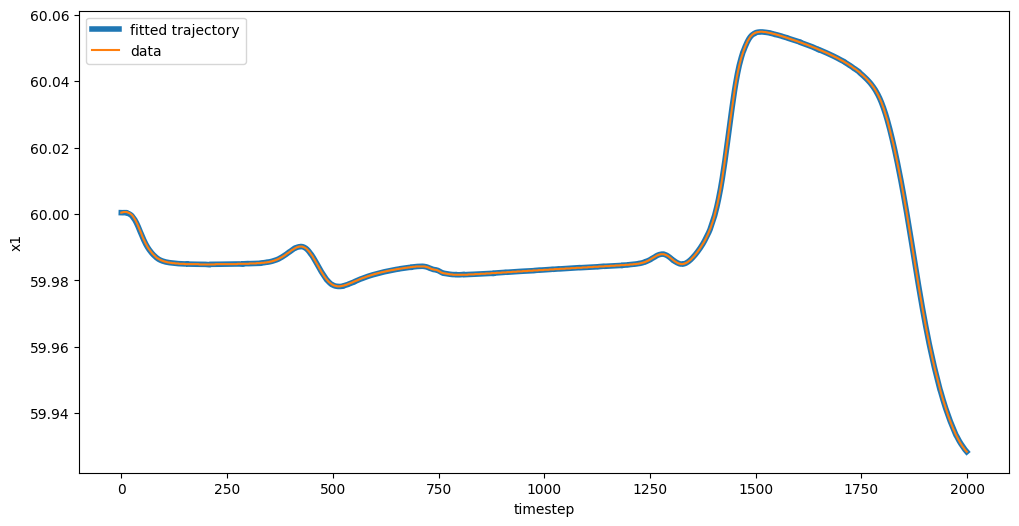

In [59]:
plt.figure(figsize=(12, 6))
plt.plot(dataset2.ys_sol['x1'][0,0:],linewidth = 4,label= 'fitted trajectory')
plt.plot(x_i[0:,0],label = 'data')
plt.ylabel('x1')
plt.xlabel('timestep')
plt.legend()

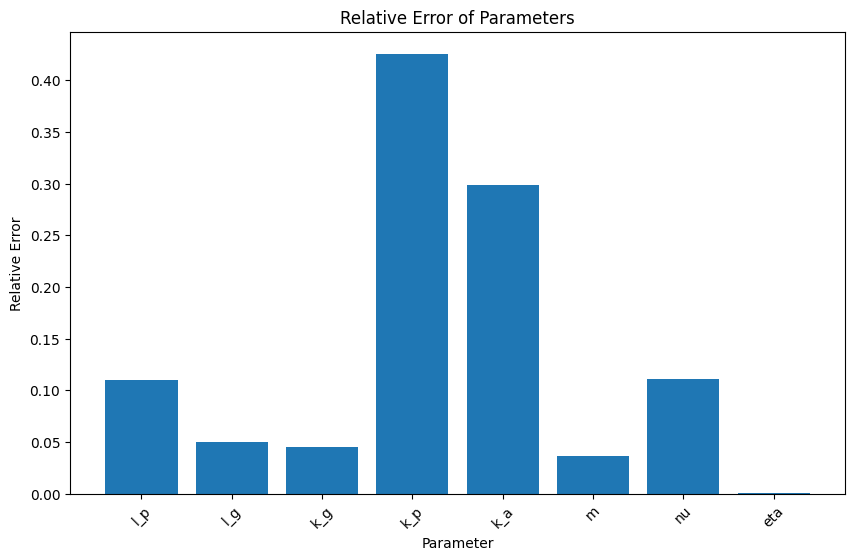

In [60]:
# Get the parameter names
param_names = list(real_params.keys()) + list(dataset2.params_train.keys())

# Calculate the relative error for each parameter
relative_errors = []
for param_name in param_names:
    real_value = real_params.get(param_name, np.nan)
    train_value = dataset2.params_train.get(param_name, np.nan)
    if np.isnan(real_value) or np.isnan(train_value):
        relative_errors.append(np.nan)
    else:
        relative_error = np.abs((train_value - real_value) / real_value)
        relative_errors.append(relative_error)

# Plot the relative errors
plt.figure(figsize=(10, 6))
plt.bar(param_names, relative_errors)
plt.xlabel('Parameter')
plt.ylabel('Relative Error')
plt.title('Relative Error of Parameters')
plt.xticks(rotation=45)
plt.show()

In [61]:
dataset2.params_train

{'eta': Array(0.80055994, dtype=float32),
 'k_a': Array(11.686715, dtype=float32),
 'k_g': Array(13.587438, dtype=float32),
 'k_p': Array(2.8515887, dtype=float32),
 'l_g': Array(1.0503243, dtype=float32),
 'l_p': Array(0.4448943, dtype=float32),
 'm': Array(1.0366882, dtype=float32),
 'nu': Array(16.667976, dtype=float32)}